# Module 5: Transfer learning - Practice

In this session, you will create a **deep convolutional neural network** (DCNN)
to distinguish **dogs vs cats** images.
You will be able to train a very accurate model based on a dataset containing 20k+ images using
a deep learning technique called transfer learning, which is typically done because of:

1. Difficulties in data acuisition or limited amount of data
2. Prohibitively long training duration of a highly complex model

The Transfer Learning technique is to reuse an existing DCNN as **feature extraction**
along with its trained weights for solving a problem in a slightly different domain.
Deep convolutional networks exploit the hierarchical distributed feature representations where,
lower levels of layers contain more generic features (e.g. edges or blobs) that should be useful to many tasks,
while higher levels of layers extracts information relevant to some particular application of the network.

Read more in this very popular article: [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In this session we will keep using **Keras** to create a deep convolutional network from high level.

Keras documentation click [here](https://keras.io/layers/core/).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools, functools
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K

import tf_threads
tfconfig = tf_threads.limit(tf, 2)
session = tf.Session(config=tfconfig)
K.set_session(session)

import h5py
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Reshape, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


# Load dataset

Here's directory structure for this dataset:
~~~
DogsCats/
    train/
        cat.001.jpg
        cat.002.jpg
        dog.001.jpg
        dog.002.jpg
~~~

Run this cell to show a cat image!

Showing the train/cat.100.jpg, full path : /dsa/data/all_datasets/transfer_learning/DogsCats/train/cat.100.jpg


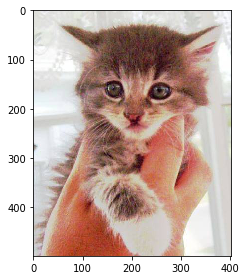

In [35]:
DATASET = lambda fname = '': os.path.join('/dsa/data/all_datasets/transfer_learning/DogsCats', fname)
assert os.path.exists(DATASET())

plt.figure()

# Study This Statement:
print("Showing the train/cat.100.jpg, full path : {}".format(
            DATASET('train/cat.100.jpg')
        )
     )

imshow(imread(DATASET('train/cat.100.jpg')))

In [3]:
help(imshow)

Help on function imshow in module skimage.io._io:

imshow(arr, plugin=None, **plugin_args)
    Display an image.
    
    Parameters
    ----------
    arr : ndarray or str
        Image data or name of image file.
    plugin : str
        Name of plugin to use.  By default, the different plugins are
        tried (starting with the Python Imaging Library) until a suitable
        candidate is found.
    
    Other parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.



### Show another image of a dog, say '`dog.200.jpg`' from the training folder.

Showing dog.200.jpg, full path:/dsa/data/all_datasets/transfer_learning/DogsCats/train/dog.200.jpg


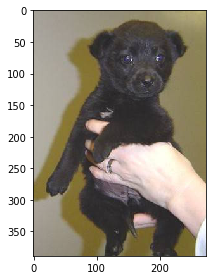

In [4]:
# Add code below this comment  (Question #P5101)
# ----------------------------------
plt.figure()

print("Showing dog.200.jpg, full path:{}".format(DATASET('train/dog.200.jpg')))

imshow(imread(DATASET('train/dog.200.jpg')))

# Create a DCNN model based on VGG16

In the following cell, you will create a computational graph.
This time we will transfer [VGG Networks](http://www.robots.ox.ac.uk/~vgg/research/very_deep/),
[or academic paper: VGG16](https://arxiv.org/abs/1409.1556) network along with its
weights instead of creating the neural network from scratch.
But we will detach dense layers from VGG16 network and add our own.
During training, all the weights within VGG16 will stay locked, so we'll be using 
whatever features VGG16 gives us.
Only weights in the dense layers will be trained, and this part serves as a classifier.

**Tip**: _If you want some hints and review, please go back to the [MNIST lab](../labs/MNIST.ipynb)._

Steps:

1. Specify input shape (150, 150, 3)
2. Lock weights in VGG16 by setting each
```
layer.trainable = False
```
3. Complete dense layers
  * the 1st one will have **256** units of neuron with **relu** activation.
  * the 2nd one will have **1** unit of neuron with **sigmoid** activation.

In [8]:
# Complete code below this comment  (Question #P5102)
# ----------------------------------
images = Input(shape = (150,150,3))

vgg16 = VGG16(weights='imagenet', include_top=False)

# Lock the VGG16 Layers
for layer in vgg16.layers:
    layer.trainable = False    # Look above

classifier = [
    Flatten(input_shape = vgg16.output_shape[1:]),
    
    # Size, and Neuron Type
    Dense(256, activation='relu', name = 'dense_1'),
    Dropout(0.5),

    # Size, and Neuron Type
    Dense(1, activation='sigmoid', name = 'dense_2'),
]

y_pred = functools.reduce(lambda f1, f2: f2(f1), [images, vgg16]+classifier)

model = Model(inputs = [images], outputs = [y_pred])

#### Compile this DCNN model.

* **'binary_crossentropy'** as loss function
* SGD optimizer with
  * **learning rate (lr)  = $1 \times 10^{-4}$ ** and
  * **momentum = 0.9**.
* For `metrics` use only :
```
['accuracy']
```

In [9]:
# Complete code below this comment  (Question #P5103)
# ----------------------------------
model.compile(loss='binary_crossentropy',
    optimizer=SGD(lr=.0001, momentum=.9),
    metrics=['accuracy'])

Print a model summary. 
Notice that number of trainable params should be different from total params, 
which indicates that you have locked VGG16 successfully.

In [10]:
# Add code below this comment  (Question #P5104)
# ----------------------------------
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
________________________________________________________

# Training a DCNN model using transfer learning

Now we are going to create generators that generate batches for us.

* set batch size = **20**
* set image resolution to **(150,150)** (this is what target_size is referring to)
* set class mode as **'binary'** because there are only two classes: dog and cat

In [11]:
# Complete code below this comment  (Question #P5105)
# ----------------------------------
BATCH_SIZE = 20

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [12]:
# Complete code below this comment  (Question #P5106)
# ----------------------------------
train_generator = train_datagen.flow_from_directory(
    DATASET('TransferLearning/train'),
    target_size=(150,150),
    batch_size=BATCH_SIZE,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    DATASET('TransferLearning/validation'),
    target_size=(150,150),
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 24200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


#### Fit this DCNN.

<span style="background:yellow">**NOTE:** This will take a **couple hours** for 1 epochs, depending on system load.</span>

You should let it run a bit, then move on with loading the weights we have trained for you.

You can interupt with `Kernel > Interrupt`

In [13]:
try:
    model.fit_generator(
        train_generator, steps_per_epoch = 12500 // BATCH_SIZE,
        validation_data=validation_generator, validation_steps=800 // BATCH_SIZE,
        epochs=1) # Normally a few more epochs will be expected.
except KeyboardInterrupt:
    """Select from top menu Kernel->Interrupt to quit training and
    leave model parameters (or weights) as they are."""

Epoch 1/1
366/625 [================>.............] - ETA: 2491s - loss: 0.5755 - acc: 0.6997

If you let this run through a few epochs, you will see lines such as this:

```
Epoch 1/5
625/625 [==============================] - 6335s - loss: 0.5368 - acc: 0.7282 - val_loss: 0.3688 - val_acc: 0.8675
Epoch 2/5
625/625 [==============================] - 6429s - loss: 0.4119 - acc: 0.8121 - val_loss: 0.2991 - val_acc: 0.8875
```

### Saving the learned model

If you let
Here how to save this model. 
This requires that `h5py` has been installed. 

In [15]:
model.save_weights('./weights_dogs_cats.h5')
os.path.exists('./weights_dogs_cats.h5')

True

# Evaluation

Now that we've gone through the creation of a model, 
we could define a class that allows us to reuse this model more easily.

Repeat exactly what we did before to **complete this DogsVsCats classs**.

In [22]:
# Complete code below this comment  (Question #P5107)
# ----------------------------------
class DogsVsCats(Model):
    def __init__(self):
        self.images = Input(shape=(150,150,3))
        self.vgg16 = VGG16(weights='imagenet',include_top=False)
        
        for layer in self.vgg16.layers:
            layer.trainable = False
    
        
        classifier = [
            Flatten(input_shape = self.vgg16.output_shape[1:]),
            
            Dense(256, activation = 'relu', name = 'dense_1'),
            Dropout(.5),
            
            Dense(1, activation = 'sigmoid', name = 'dense_2'),
            
        ]

        self.prediction = functools.reduce(lambda f1, f2: f2(f1), [self.images, self.vgg16]+classifier)
        
        super(DogsVsCats, self).__init__(
            inputs = [self.images],
            outputs = [self.prediction]
        )
        
        self.compile(loss = 'binary_crossentropy',
                    optimizer = SGD(lr=.0001,momentum = .9),
                    metrics =['accuracy'])
        
    def freeze_vgg16(trainable = False):
        for layer in self.vgg16.layers:
            layer.trainable = trainable

Create a new model and load in these weights we just saved.

load_weights() will only need **a file path** as an argument.

In [23]:
# Complete code below this comment  (Question #P5108)
# ----------------------------------
new_model = DogsVsCats()
new_model.load_weights('./weights_dogs_cats.h5')

Evaluate this model. Use **validation_generator** to provide data.

In [24]:
# Complete code below this comment  (Question #P5109)
# ----------------------------------
loss, accuracy = new_model.evaluate_generator(validation_generator, steps = 800 // BATCH_SIZE)
print('loss:', loss, 'accuracy:', accuracy)

loss: 0.422058670223 accuracy: 0.847500002384


Here's how you can make a prediction for one image using this model.

Cat


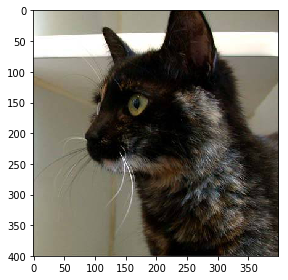

In [25]:
im_test = imread(DATASET('test1/5.jpg'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect') i
y_pred = new_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Cat', 'Dog'][y_pred>=0.5])

## Create another model with DogsVsCats()
... and load in some weights that we have trained for you over 50 epochs at  
"`/dsa/data/all_datasets/transfer_learning/DogsCats/weights_dogs_cats.h5"`

Name the new model <span style="background: yellow;">"pretrained_model"</span>.

In [27]:
assert os.path.exists('/dsa/data/all_datasets/transfer_learning/DogsCats/weights_dogs_cats.h5')

# Add code below this comment  (Question #P5110)
# ----------------------------------
pretrained_model = DogsVsCats()
pretrained_model.load_weights("/dsa/data/all_datasets/transfer_learning/DogsCats/weights_dogs_cats.h5")

#### Evaluate accuracy of this model.

In [29]:
# Add code below this comment  (Question #P5111)
# ----------------------------------
loss,accuracy = pretrained_model.evaluate_generator(validation_generator,steps= 800//BATCH_SIZE)
print('loss:', loss,'accuracy:',accuracy)



loss: 0.19926981898 accuracy: 0.912499992549


#### [Optional] Make a prediction of any other single image like we did before.

Cat


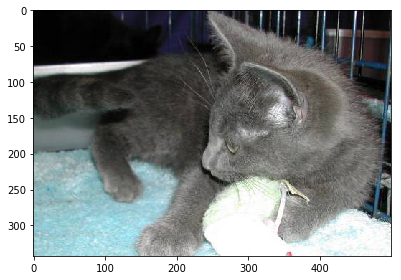

In [44]:
# Try whatever you want below this comment  (Question #P5112)
# ----------------------------------
im_test = imread(DATASET('test1/100.jpg'))
imshow(im_test)
im_test = resize(im_test,(150,150),mode='reflect')
y_pred = pretrained_model.predict(np.expand_dims(im_test,0)).squeeze()
print(['Cat','Dog'][y_pred>=0.8])

# Save your notebook!